### Bayesian constraint relaxation (Sayan Patra's code):

In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, matplotlib.pyplot as plt, pickle
from tqdm import trange
import scipy, pystan as ps
%matplotlib inline
from time import time
from pylab import plot, show, legend

#### Compile Stan model:

In [2]:
sm = ps.StanModel(file="brain_sayan_core.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc22e6617bb703b07d6d9af0b6923715 NOW.


#### Load data from file and prepare stan data list:

In [3]:
from numpy import loadtxt

X = np.zeros((42,68,68))
for i in range(42) :
    name = "/home/postdoc/dsen/Desktop/projeted_posterior/brain_data/data_column"+str(i+1)
    X[i] = loadtxt(name, comments="#", delimiter=" ", unpack=False)
X = X.astype(int)

# N = 21 
# m = np.shape(X)[1]
# p = 10
# a = 1/m
# data = dict(N=N, m=m, p=p, X=X[:N], alpha=1/m, lmbda=0.5)

N = 21 
m = 68
p = 10
data = dict(N=N, m=m, p=p, X=X[:N,:m,:m], alpha=1./m, tau=1e-3)

print(np.mean(X[:N,:m,:m]))

0.3557422969187675


#### Initialise parameters for sampling:

In [4]:
Z_ini = npr.randn(m,m)
pp = np.mean(X[:N,:m,:m],0)
pp[pp==0] = 0.01
pp[pp==1] = 0.99

eg_p = np.linalg.eig(np.log(pp/(1-pp)))
U_ini = eg_p[1][:,:p]
D_ini = np.transpose(np.reshape(np.ravel([np.abs(eg_p[0][:p])]*N), (p,N), order='C'))

etaU_ini= npr.rand(m,p)
sigsqZ_ini = npr.rand()
sigsqD_ini = npr.rand(p)

def initfun():
    return dict(Z=Z_ini, U=U_ini, D=D_ini, etaU=etaU_ini, sigsqZ=sigsqZ_ini, sigsqD=sigsqD_ini)

#### Sample using stan:

In [5]:
control = dict(max_treedepth=10)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=10, chains=10, iter=2_000, init=initfun, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit)
trace = fit.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


717.46 minutes to run
Inference for Stan model: anon_model_cc22e6617bb703b07d6d9af0b6923715.
10 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=10000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]        0.05    0.19   0.46  -1.51   0.05   0.14   0.23   0.63      6   2.97
Z[2,1]       -0.55     0.1   0.38  -1.56  -0.71  -0.48  -0.32   0.03     13   2.14
Z[3,1]        1.62    0.16   0.38   1.18    1.4   1.48    1.7   2.68      6   4.32
Z[4,1]       -0.95    0.21   0.49  -1.64  -1.36  -1.15  -0.44  -0.08      6   3.97
Z[5,1]        0.39    0.26   0.61  -1.35   0.27    0.5   0.71   1.32      6   5.12
Z[6,1]       -0.04    0.13   0.35  -1.04  -0.11   0.04   0.16   0.56      7   2.79
Z[7,1]         1.2    0.07    0.2   0.68   1.11   1.21   1.31   1.57      9   2.27
Z[8,1]       -0.78    0.16   0.43   -1.3  -1.06  -0.89  -0.56   0.49      7    2.9
Z[9,1]       -0.42    0.11   0.32  -0.94

#### Save data:

In [6]:
name = '/xtmp/projected_posterior_data/brain_analysis/MCMC_output/trace_core'
with open(name + '.pkl', 'wb') as f:
    pickle.dump(trace, f, pickle.HIGHEST_PROTOCOL)
    
# with open(name + '.pkl', 'rb') as f: tt = pickle.load(f)

#### Check if constraint is satisfied among posterior samples:

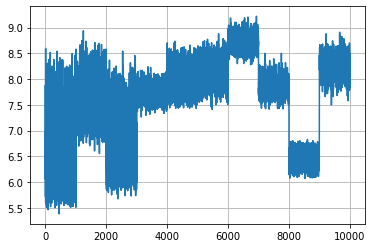

In [7]:
err = [np.sum(np.abs(np.matmul(trace['U'][i].transpose(),trace['U'][i]) - np.eye(p))) 
       for i in range(np.shape(trace['U'])[0])]
plt.plot(err)
plt.grid(True)

In [8]:
np.mean(err)

7.606030635570702

#### Read data:

In [9]:
name = '/xtmp/projected_posterior_data/brain_analysis/MCMC_output/trace_core'
with open(name + '.pkl', 'rb') as f: trace = pickle.load(f)

#### Plot log-likelihoods of posterior samples:

In [10]:
def log_ll(X, Z, U, D, tau=1e-3) :
    ll = 0
    N = np.shape(X)[0]
    m, p = np.shape(U)
    for n in range(N) :
        ZUDU = Z + np.matmul(np.matmul(U, np.diag(D[n])), U.transpose())
        probs = 1/(1+np.exp(-ZUDU))
        probs[probs==1] = 1-1e-10
        probs[probs==0] = 1e-10
        ll += np.sum(X[n]*np.log(probs) + (1-X[n])*np.log(1-probs))
    ll += -1/tau*np.linalg.norm(np.matmul(U.transpose(),U)-np.eye(p))**2
    return ll

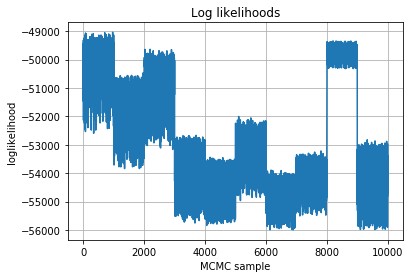

In [11]:
Nsamples = np.shape(trace['Z'])[0]
log_lls = [log_ll(X[:N,:m,:m], trace['Z'][i], trace['U'][i], trace['D'][i]) for i in range(Nsamples)]

plt.plot(log_lls)
plt.grid(True)
plt.title("Log likelihoods");
plt.xlabel("MCMC sample");
plt.ylabel("loglikelihood");

#### Out of sample log likelihood:

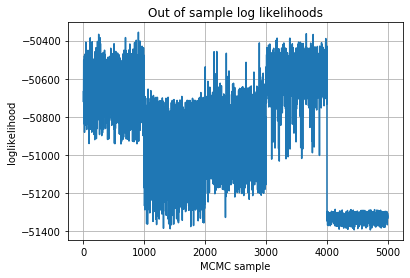

In [11]:
log_lls_oos = [log_ll(X[N:,:m,:m], trace['Z'][i], trace['U'][i], trace['D'][i]) for i in range(Nsamples)]

plt.plot(log_lls_oos)
plt.grid(True)
plt.title("Out of sample log likelihoods");
plt.xlabel("MCMC sample");
plt.ylabel("loglikelihood");